In [89]:
#import necessary packages

import imageio

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from keras import models
from keras import layers
from keras.applications import VGG19 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator



from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory




In [90]:
path_to_data = '/home/meth/Documents/FIELDWORK/DEMO PROJECT/ocular/classes'

In [91]:
tf.experimental.numpy.experimental_enable_numpy_behavior()
keras.utils.set_random_seed(87)

In [92]:
train_ds, valid_ds= image_dataset_from_directory(
    directory='classes',
    validation_split= 0.2,
    labels='inferred',
    batch_size=64,
    image_size=((200,200)),
    subset='both',
    class_names=['mild','moderate','no_dr','proliferate_dR','severe'],
    seed=1234,
    shuffle=True

)

Found 3383 files belonging to 5 classes.
Using 2707 files for training.
Using 676 files for validation.


plotting images


Data augmentation

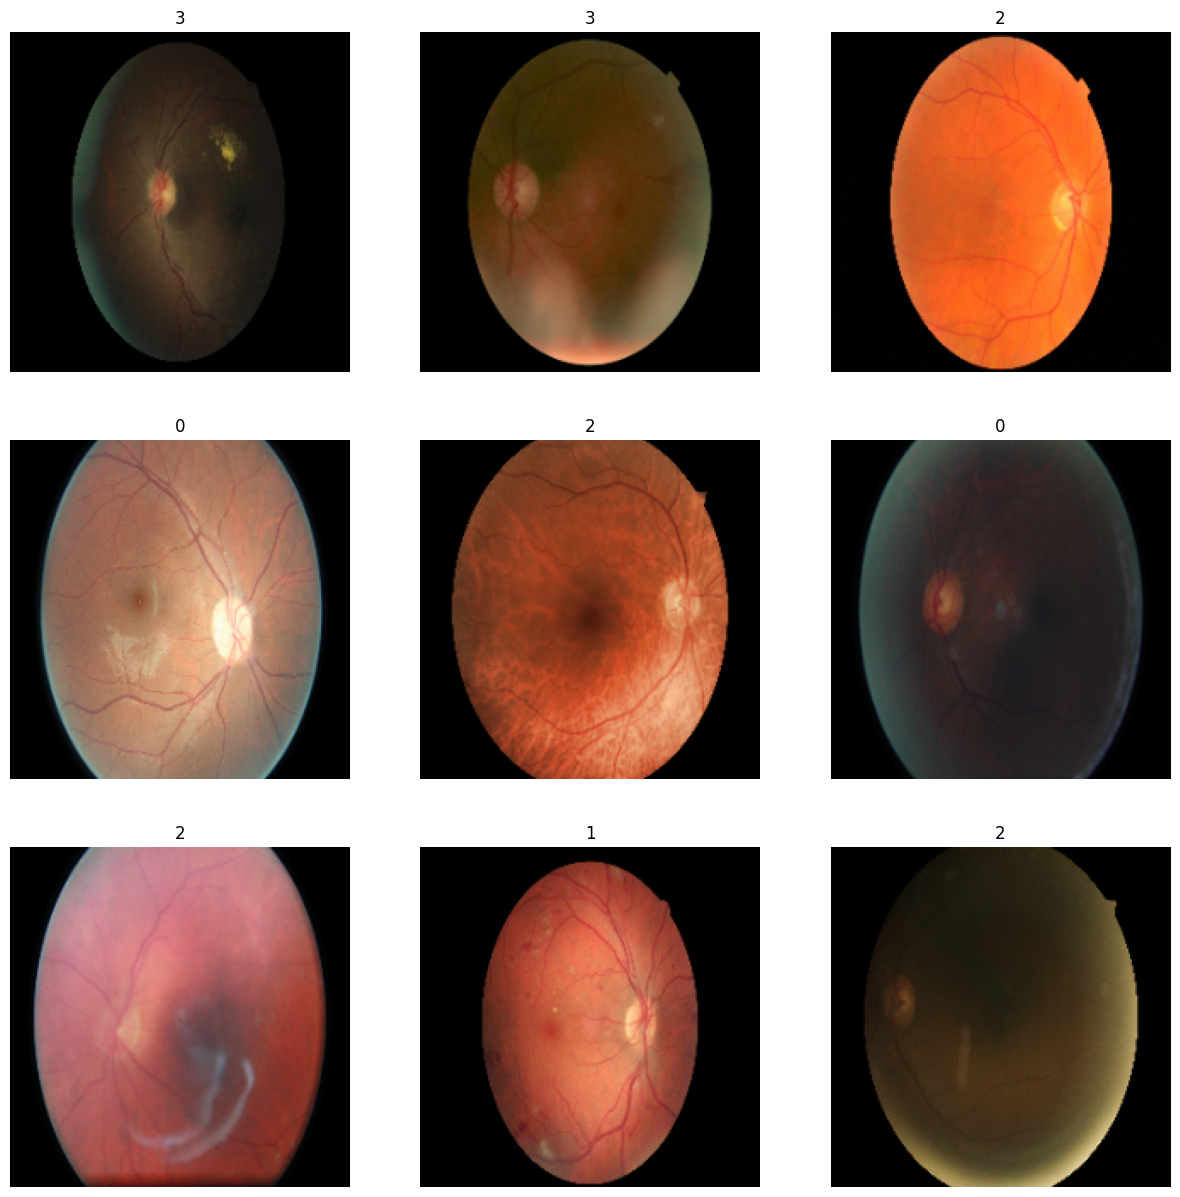

In [93]:
plt.figure(figsize=(15, 15))  # Smaller figure size for easier viewing

for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype('uint8'))  
        plt.title(label[i].numpy())  
        plt.axis('off')
plt.show()  


In [94]:
from keras import models
from keras import layers#data augumentation 
data_augs= keras.Sequential([layers.RandomRotation(0.1),
    layers.RandomContrast(0.7),
    layers.RandomZoom(0.2),
    layers.RandomFlip("vertical"),
    layers.RandomBrightness(factor=0.2)
    
])


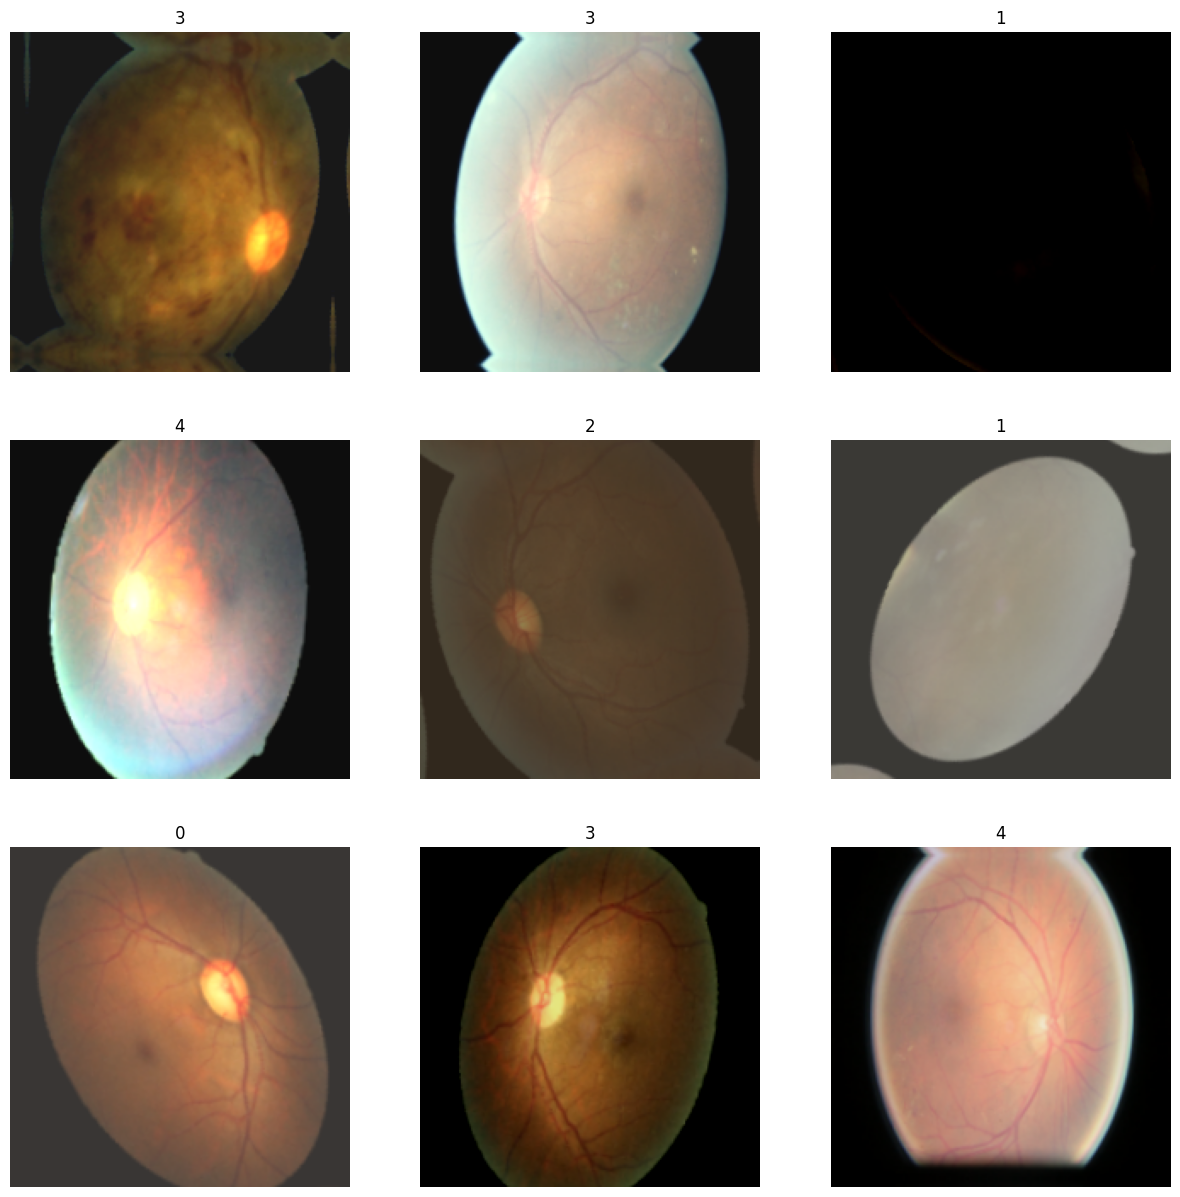

In [95]:
#visualizing sample images


plt.figure(figsize=(15,15))
for image,label in train_ds.take(1):
    for i in range(9):
        aug= data_augs(image)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(np.asarray(aug[i].astype('uint8')))
        plt.title(label[i].numpy())
        plt.axis('off')

transfer learning

In [96]:


vgg= VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(200,200,3))
vgg.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [97]:

model = keras.Sequential()
model.add(vgg)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 flatten_8 (Flatten)         (None, 18432)             0         
                                                                 
 dense_17 (Dense)            (None, 256)               4718848   
                                                                 
 dense_18 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 24744517 (94.39 MB)
Trainable params: 24744517 (94.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [98]:
print(len(model.trainable_weights))
vgg.trainable=False
print(len(model.trainable_weights))

36
4


In [99]:
vgg.trainable = True
set_trainable = False
for layer in vgg.layers:
   if layer.name == 'block5_conv1':
     set_trainable = True
   if set_trainable:
     layer.trainable = True
   else:
     layer.trainable = False

In [100]:
path_to_data = '/home/meth/Documents/FIELDWORK/DEMO PROJECT/ocular/classes'
# Create an instance of ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize the images to [0, 1]
    shear_range=0.2,           # Apply shear transformation
    zoom_range=0.2,            # Apply zoom transformation
    horizontal_flip=True,      # Randomly flip images horizontally
    validation_split=0.2       # Split the data into training and validation sets
)
train_generator = train_datagen.flow_from_directory('/home/meth/Documents/FIELDWORK/DEMO PROJECT/ocular/classes',   
    target_size=(224, 224),    # Resize images to 200x200 pixels
    batch_size=32,             # Number of images to return in each batch
    class_mode='sparse',       # Use 'sparse' for integer labels
    subset='training'          # Specify this as the training set
)

validation_generator = train_datagen.flow_from_directory('/home/meth/Documents/FIELDWORK/DEMO PROJECT/ocular/classes',
    target_size=(200, 200),    # Resize images to 200x200 pixels
    batch_size=32,             # Number of images to return in each batch
    class_mode='sparse',       # Use 'sparse' for integer labels
    subset='validation'        # Specify this as the validation set
)


Found 2709 images belonging to 5 classes.
Found 674 images belonging to 5 classes.


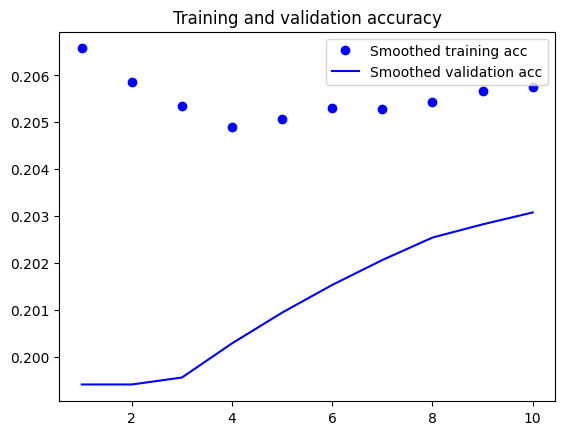

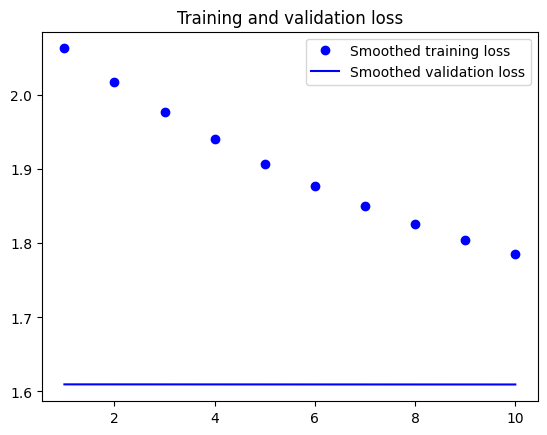

In [102]:
import numpy as np

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Assuming 'history' is the output of model.fit
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the epochs
epochs = range(1, len(accuracy) + 1)

# Plot smoothed accuracy
plt.plot(epochs, smooth_curve(accuracy), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_accuracy), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot smoothed loss
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


/home/meth/Documents/FIELDWORK/DEMO PROJECT/ocular/classes

In [103]:
# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sequential_11/dense_17/MatMul defined at (most recent call last):
  File "/home/meth/anaconda3/envs/anuji2/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/meth/anaconda3/envs/anuji2/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/meth/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/meth/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/meth/anaconda3/envs/anuji2/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/meth/anaconda3/envs/anuji2/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/meth/anaconda3/envs/anuji2/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/meth/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/meth/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/meth/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/meth/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/meth/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/meth/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_11325/515026356.py", line 9, in <module>

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 241, in call

Matrix size-incompatible: In[0]: [32,25088], In[1]: [18432,256]
	 [[{{node sequential_11/dense_17/MatMul}}]] [Op:__inference_train_function_94529]

model building

In [ ]:
#input layer
inputs =keras.Input(shape=(200,200,3))
input_augs= data_augs(inputs)
input_normalized = layers.Rescaling(1./255)(input_augs)

# convolution layers
conv1= layers.Conv2D(filters=32, kernel_size=5, activation='relu')(input_normalized)

conv1_pooling= layers.MaxPooling2D(pool_size=2)(conv1)

conv2 = layers.Conv2D(filters=64, kernel_size=5, activation='relu')(conv1_pooling)

conv2_pooling= layers.MaxPooling2D(pool_size=2)(conv2)


conv3 = layers.Conv2D(filters=96, kernel_size=5, activation='relu')(conv2_pooling)

conv3_pooling= layers.MaxPooling2D(pool_size=2)(conv3)







#flattening 
inputs_flat=layers.Flatten()(conv3_pooling)

#hidden layers
hidden_1=layers.Dense(units=100, use_bias=True, activation ='relu')(inputs_flat)
hidden_2=layers.Dense(units=100, use_bias=True, activation ='relu')(hidden_1)








#output layer
output_layer=layers.Dense(units=5, use_bias=True, activation ='softmax')(hidden_2)

#model instance
model=keras.Model(inputs=inputs, outputs=output_layer)

#model summary
model.summary()




Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 110, 110, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 64)      51264     
                                                           

In [ ]:
#OPTIMIZER
optim=tf.keras.optimizers.Adam(learning_rate=0.00001)


In [ ]:
#defining optimizer and loss evaluation accuracy
model.compile(
    loss ='sparse_categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy']

 )


#training the model 
train_log=model.fit(x=train_ds,epochs=10, validation_data=valid_ds)

Epoch 1/10
43/43 [==============================] - 6s 108ms/step - loss: 1.6104 - accuracy: 0.1914 - val_loss: 1.6080 - val_accuracy: 0.2160
Epoch 2/10
43/43 [==============================] - 5s 106ms/step - loss: 1.6081 - accuracy: 0.2157 - val_loss: 1.6064 - val_accuracy: 0.2367
Epoch 3/10
43/43 [==============================] - 5s 106ms/step - loss: 1.6070 - accuracy: 0.2154 - val_loss: 1.6057 - val_accuracy: 0.2293
Epoch 4/10
43/43 [==============================] - 5s 106ms/step - loss: 1.6075 - accuracy: 0.2198 - val_loss: 1.6038 - val_accuracy: 0.2308
Epoch 5/10
43/43 [==============================] - 5s 106ms/step - loss: 1.6062 - accuracy: 0.2213 - val_loss: 1.6017 - val_accuracy: 0.2618
Epoch 6/10
43/43 [==============================] - 5s 107ms/step - loss: 1.6049 - accuracy: 0.2231 - val_loss: 1.6028 - val_accuracy: 0.2426
Epoch 7/10
43/43 [==============================] - 5s 106ms/step - loss: 1.6029 - accuracy: 0.2261 - val_loss: 1.6010 - val_accuracy: 0.2441
Epoch 

In [ ]:
model.evaluate(valid_ds)
valid_loss, valid_acc = model.evaluate(valid_ds)
print(' validation loss; ', valid_loss)
print('validation accuracy ;' , valid_acc)

11/11 [==============================] - 1s 47ms/step - loss: 1.5966 - accuracy: 0.2574
 validation loss;  1.5966073274612427
validation accuracy ; 0.2573964595794678


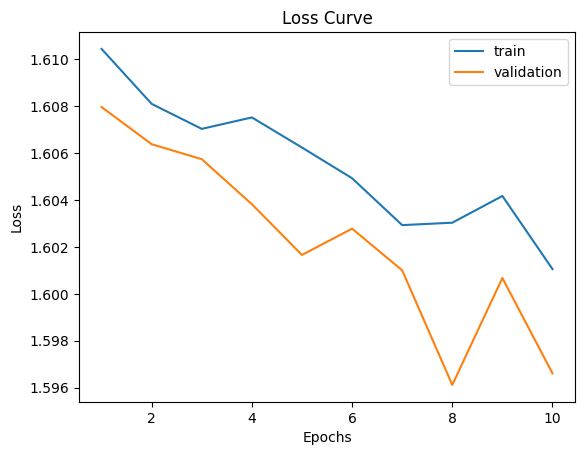

In [ ]:
# #loss graph 
ep= np.arange(1,11)
loss = train_log.history['loss']
validation_loss = train_log.history['val_loss']

plt.plot(ep,loss)
plt.plot(ep,validation_loss)
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','validation'])


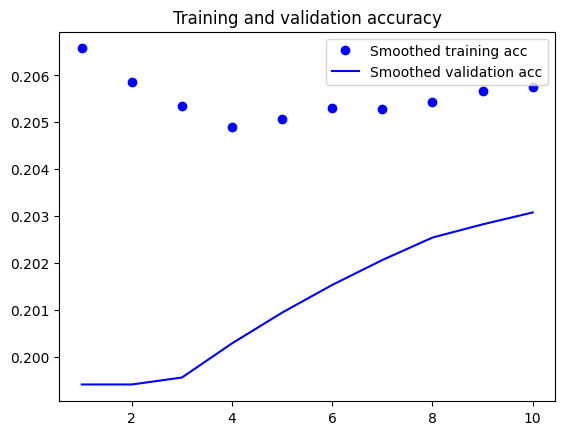

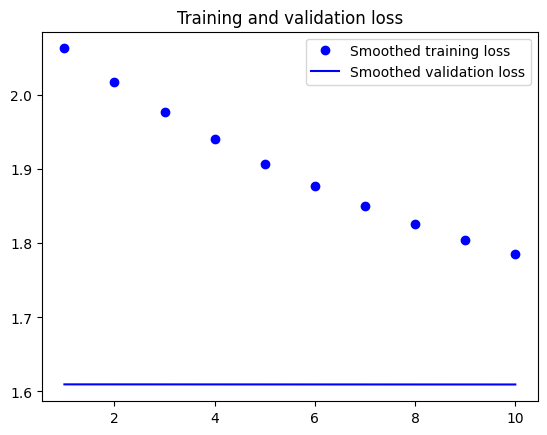

In [ ]:
import numpy as np

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Assuming 'history' is the output of model.fit
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the epochs
epochs = range(1, len(accuracy) + 1)

# Plot smoothed accuracy
plt.plot(epochs, smooth_curve(accuracy), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_accuracy), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot smoothed loss
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have a directory for test images
test_dir = '/home/meth/Documents/FIELDWORK/DEMO PROJECT/ocular/classes'

# Create an instance of ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale the test images

# Define test_generator using flow_from_directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),  # Resize images to 200x200 pixels
    batch_size=32,           # Number of images to return in each batch
    class_mode='sparse'      # Use 'sparse' for integer labels
)

# Evaluate the model using the test_generator
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('Test accuracy:', test_acc)


Found 3383 images belonging to 5 classes.


InvalidArgumentError: Graph execution error:

Detected at node model_2/dense_14/MatMul defined at (most recent call last):
  File "/home/meth/anaconda3/envs/anuji2/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/meth/anaconda3/envs/anuji2/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/meth/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/meth/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/meth/anaconda3/envs/anuji2/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/meth/anaconda3/envs/anuji2/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/meth/anaconda3/envs/anuji2/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/meth/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/meth/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/meth/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/meth/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/meth/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/meth/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/meth/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_11325/3850600112.py", line 18, in <module>

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1917, in test_step

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/meth/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 241, in call

Matrix size-incompatible: In[0]: [32,42336], In[1]: [55296,100]
	 [[{{node model_2/dense_14/MatMul}}]] [Op:__inference_test_function_86897]

In [ ]:
#retrieve model prediction
y_pred= model.predict(valid_ds)
y_pred_classes= np.argmax(y_pred,axis=1)
y_true= np.concatenate([y for x, y in valid_ds],axis=0)

11/11 [==============================] - 0s 38ms/step


In [ ]:
#classification report
from sklearn.metrics import classification_report

print(classification_report(y_true,y_pred_classes,target_names=['mild','moderate','no_dr','proliferate_dR','severe']))

                precision    recall  f1-score   support

          mild       0.20      0.19      0.20       125
      moderate       0.19      0.46      0.27       137
         no_dr       0.33      0.24      0.28       131
proliferate_dR       0.56      0.16      0.25       140
        severe       0.21      0.13      0.16       143

      accuracy                           0.24       676
     macro avg       0.30      0.24      0.23       676
  weighted avg       0.30      0.24      0.23       676



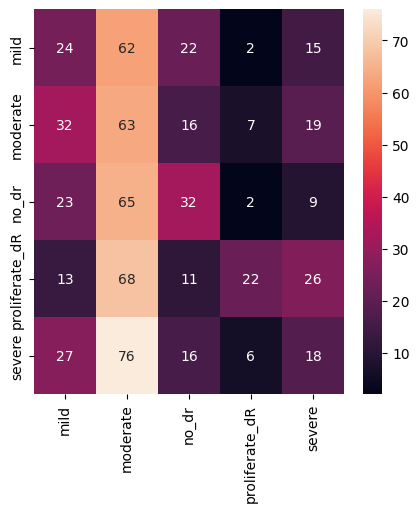

In [ ]:
#confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,fmt="d",xticklabels=['mild','moderate','no_dr','proliferate_dR','severe'], yticklabels=['mild','moderate','no_dr','proliferate_dR','severe'],)
plt.show()

In [ ]:
model.save('model_58.keras')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Flatten or GlobalAveragePooling2D
    Flatten(),  # or GlobalAveragePooling2D() depending on your architecture
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')  # Assuming 5 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
